## import libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 300)
import praw #reddit data api
import ffn #for loading financial data
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import re #regex
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #VADER sentiment model
import requests
import json
import csv
import time
import datetime

/Users/ming/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
import tensorflow as tf
from tensorflow import keras
tf.test.gpu_device_name() #run to make sure tensorflow is connected to gpu (if applicable)

''

# positive/negative sentiment analysis using VADER

## get comments from reddit using pushshift and praw

In [3]:
#function to get data from pushshift api
def getPushshiftData(query, after, before, sub):
    url = 'https://api.pushshift.io/reddit/search/submission/?title='+str(query)+'&size=1000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)
    print(url)
    r = requests.get(url)
    data = json.loads(r.text)
    return data['data']

#get relevant data from data extracted using previous function
def collectSubData(subm):
    subData = [subm['id'], subm['title'], subm['url'], datetime.datetime.fromtimestamp(subm['created_utc']).date()]
    try:
        flair = subm['link_flair_text']
    except KeyError:
        flair = "NaN"
    subData.append(flair)
    subStats.append(subData)

In [4]:
#Subreddit to query
sub='wallstreetbets'
#before and after dates
before = "1594339200" #july 10 2020
after = "1498867200" #july 1 2017
#query string
query = "Daily Discussion Thread"
subCount = 0
subStats = []

In [5]:
data = getPushshiftData(query, after, before, sub)
# Will run until all posts have been gathered 
# from the 'after' date up until before date
while len(data) > 0:
    for submission in data:
        collectSubData(submission)
        subCount+=1
    # Calls getPushshiftData() with the created date of the last submission
    print(len(data))
    print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
    after = data[-1]['created_utc']
    data = getPushshiftData(query, after, before, sub)

https://api.pushshift.io/reddit/search/submission/?title=Daily Discussion Thread&size=1000&after=1498867200&before=1594339200&subreddit=wallstreetbets
100
2018-04-25 13:08:40
https://api.pushshift.io/reddit/search/submission/?title=Daily Discussion Thread&size=1000&after=1524658120&before=1594339200&subreddit=wallstreetbets
99
2018-09-10 12:12:44
https://api.pushshift.io/reddit/search/submission/?title=Daily Discussion Thread&size=1000&after=1536577964&before=1594339200&subreddit=wallstreetbets
100
2019-01-21 11:05:54
https://api.pushshift.io/reddit/search/submission/?title=Daily Discussion Thread&size=1000&after=1548068754&before=1594339200&subreddit=wallstreetbets
100
2019-06-10 12:05:59
https://api.pushshift.io/reddit/search/submission/?title=Daily Discussion Thread&size=1000&after=1560164759&before=1594339200&subreddit=wallstreetbets
100
2019-10-10 12:05:28
https://api.pushshift.io/reddit/search/submission/?title=Daily Discussion Thread&size=1000&after=1570705528&before=1594339200&

In [6]:
#organize data into dataframe
data={}
ids=[]
titles=[]
urls=[]
dates=[]
flairs=[]
for stat in subStats:
    ids.append(stat[0])
    titles.append(stat[1])
    urls.append(stat[2])
    dates.append(stat[3])
    flairs.append(stat[4])
data['id']=ids
data['title']=titles
data['url']=urls
data['date']=dates
data['flair']=flairs
df_1=pd.DataFrame(data)
df_1=df_1[df_1['flair']=='Daily Discussion']

In [6]:
#connect to reddit api
reddit = praw.Reddit(client_id='0NrvvqH4Bj1EaA', 
                     client_secret='mjr02WtfuPsagq7Hk-fNr1HugNg',
                     password='Nanennada123',
                     user_agent='script by u/sskye123',
                     username='sskye123')
print(reddit.user.me())

sskye123


In [8]:
# collect comments using praw. Please be patient, it takes hours to run. If you just want to see the result,
# please directly go to df_1_csv = pd.read_csv('positive+negative_sentiment_data_1.csv') command to save time by using
# saved csv data
comments_by_day=[]
for url in df_1['url'].tolist():
    try:
        submission = reddit.submission(url=url)
        submission.comments.replace_more(limit=0)
        comments=list([(comment.body) for comment in submission.comments])
    except:
        comments=None
    comments_by_day.append(comments)

In [9]:
## run vader sentiment analyzer

analyser = SentimentIntensityAnalyzer()

scores=[]
for comments in comments_by_day:
    sentiment_score=0
    try:
        for comment in comments:
            sentiment_score=sentiment_score+analyser.polarity_scores(comment)['compound']
    except TypeError:
        sentiment_score=0
    
    scores.append(sentiment_score)
    
df_1['sentiment score']=scores

In [10]:
## merge with spy price and plot

spy=ffn.get('spy', start='2010-01-01')
spy_vals=[]
for date in df_1['date'].tolist():
    try:
        spy_vals.append(float(spy.loc[date]))
    except KeyError:
        spy_vals.append(None)
        
df_1['spy']=spy_vals

In [11]:
df_1=df_1[['date','sentiment score','spy']]
df_1=df_1.set_index('date')
df_1=df_1[df_1['spy'].notna()]

In [12]:
df_1.to_csv('positive+negative_sentiment_data_1.csv')

In [54]:
# Users can directly using saved csv data to run analysis to save time
df_1_csv = pd.read_csv('positive+negative_sentiment_data_1.csv')

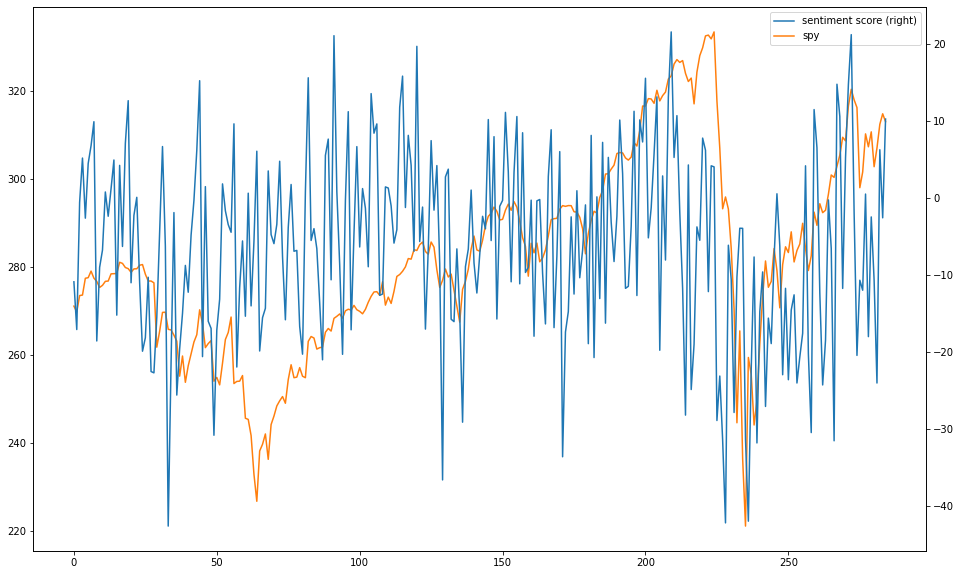

In [55]:
df_1_csv.plot(secondary_y='sentiment score', figsize=(16, 10));

In [56]:
## fourier transform

close_fft = np.fft.fft(np.asarray(df_1['sentiment score'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df['fft'].tolist())

for num_ in [5, 10, 15, 20]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    df_1_csv['fourier '+str(num_)]=np.fft.ifft(fft_list_m10)

C:\Users\nanen\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\nanen\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\nanen\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\nanen\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


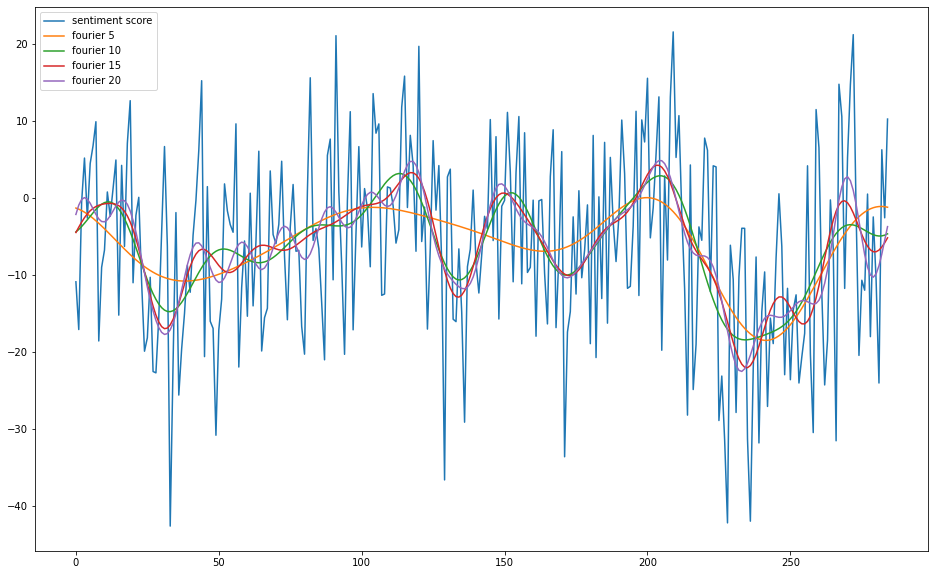

In [57]:
df_1_csv[['sentiment score', 'fourier 5', 'fourier 10', 'fourier 15', 'fourier 20']].plot(figsize=(16, 10));

C:\Users\nanen\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


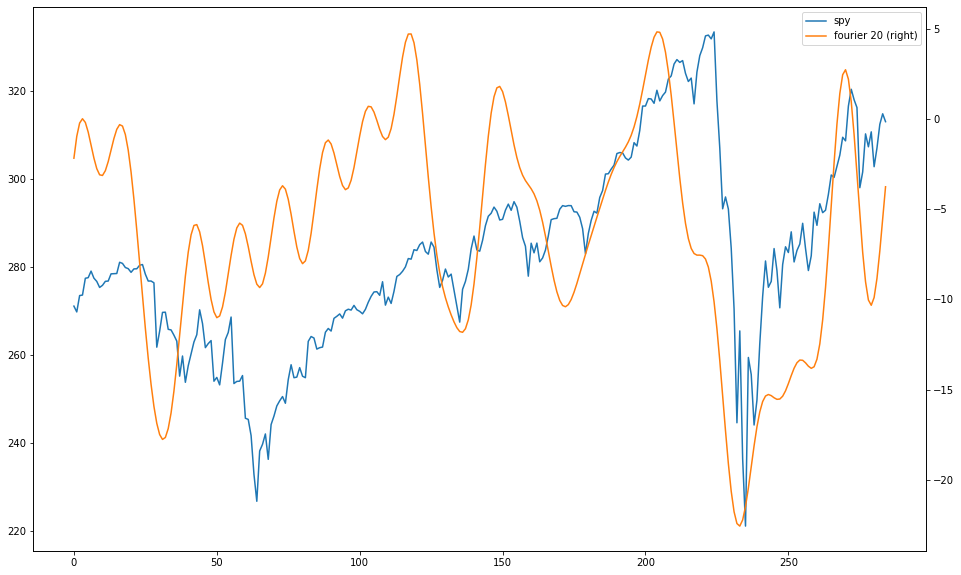

In [58]:
df_1_csv[['spy', 'fourier 20']].plot(secondary_y='fourier 20', figsize=(16, 10));

In [59]:
#normalize
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
df_1_csv['norm_price']=sc.fit_transform(df_1['spy'].to_numpy().reshape(-1, 1))
df_1_csv['spy log']=np.log(df_1['spy']/df_1['spy'].shift(1))
df_1_csv['norm_sentiment']=sc.fit_transform(df_1['sentiment score'].to_numpy().reshape(-1, 1))
df_1_csv['norm_fourier5']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_1['fourier 5'].to_numpy()])).reshape(-1, 1))
df_1_csv['norm_fourier10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_1['fourier 10'].to_numpy()])).reshape(-1, 1))
df_1_csv['norm_fourier15']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_1['fourier 15'].to_numpy()])).reshape(-1, 1))
df_1_csv['norm_fourier20']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_1['fourier 20'].to_numpy()])).reshape(-1, 1))

<ipython-input-59-c6831879258f>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  df_1_csv['norm_fourier5']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_1['fourier 5'].to_numpy()])).reshape(-1, 1))
<ipython-input-59-c6831879258f>:8: ComplexWarning: Casting complex values to real discards the imaginary part
  df_1_csv['norm_fourier10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_1['fourier 10'].to_numpy()])).reshape(-1, 1))
<ipython-input-59-c6831879258f>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  df_1_csv['norm_fourier15']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_1['fourier 15'].to_numpy()])).reshape(-1, 1))
<ipython-input-59-c6831879258f>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  df_1_csv['norm_fourier20']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_1['fourier 20'].to_numpy()])).reshape(-1, 1))


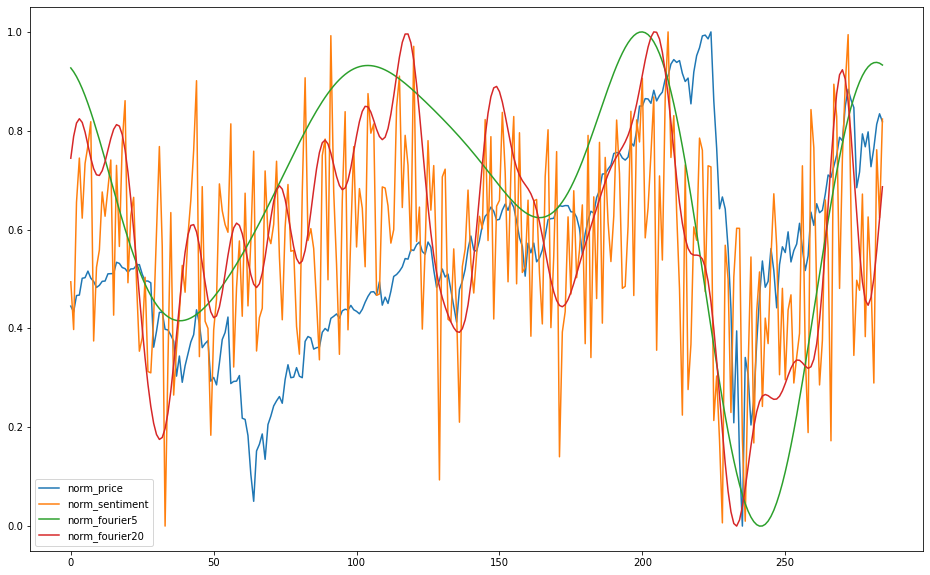

In [60]:
df_1_csv[['norm_price', 'norm_sentiment', 'norm_fourier5', 'norm_fourier20']].plot(figsize=(16, 10));

# bullish/bearish sentiment analysis using keywords

## get submission titles using pushshift

In [19]:
def getPushshiftData(query, after, before, sub):
    url = 'https://api.pushshift.io/reddit/search/submission/?title='+str(query)+'&size=1000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)
    print(url)
    
    r = requests.get(url)
    data = json.loads(r.text)
    
    return data['data']

def collectSubData(subm):
    subData = [subm['id'], subm['title'], subm['url'], datetime.datetime.fromtimestamp(subm['created_utc']).date()]
    try:
        flair = subm['link_flair_text']
    except KeyError:
        flair = "NaN"
    subData.append(flair)
    subStats.append(subData)

In [20]:
#Subreddit to query
sub='wallstreetbets'
#before and after dates
before = "1594339200" #july 10 2020
after = "1498867200" #july 1 2017
query = ""
subCount = 0
subStats = []

In [21]:
# Again, takes a long time to run and be patient. If you just want to see the result,
# please directly go to df_2_csv = pd.read_csv('bullish+bearish_sentiment_data_1.csv') command to save time by using
# saved csv data
data = getPushshiftData(query, after, before, sub)
# Will run until all posts have been gathered 
# from the 'after' date up until before date
while len(data) > 0:
    for submission in data:
        collectSubData(submission)
        subCount+=1
    # Calls getPushshiftData() with the created date of the last submission
    print(len(data))
    print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
    after = data[-1]['created_utc']
    try:
        data = getPushshiftData(query, after, before, sub)
    except:
        pass

https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1498867200&before=1594339200&subreddit=wallstreetbets
100
2017-07-03 03:16:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1499048207&before=1594339200&subreddit=wallstreetbets
100
2017-07-04 00:02:57
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1499122977&before=1594339200&subreddit=wallstreetbets
100
2017-07-05 14:35:34
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1499261734&before=1594339200&subreddit=wallstreetbets
100
2017-07-05 23:50:41
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1499295041&before=1594339200&subreddit=wallstreetbets
100
2017-07-06 20:20:27
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1499368827&before=1594339200&subreddit=wallstreetbets
100
2017-07-07 16:48:05
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1499442485&bef

100
2017-08-09 21:24:19
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1502310259&before=1594339200&subreddit=wallstreetbets
100
2017-08-10 15:12:28
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1502374348&before=1594339200&subreddit=wallstreetbets
100
2017-08-10 19:56:31
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1502391391&before=1594339200&subreddit=wallstreetbets
100
2017-08-10 22:54:21
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1502402061&before=1594339200&subreddit=wallstreetbets
100
2017-08-11 14:17:40
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1502457460&before=1594339200&subreddit=wallstreetbets
100
2017-08-11 20:58:23
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1502481503&before=1594339200&subreddit=wallstreetbets
100
2017-08-13 02:48:26
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2017-09-22 15:31:45
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1506090705&before=1594339200&subreddit=wallstreetbets
100
2017-09-23 02:43:29
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1506131009&before=1594339200&subreddit=wallstreetbets
100
2017-09-25 00:36:25
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1506296185&before=1594339200&subreddit=wallstreetbets
100
2017-09-25 19:29:29
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1506364169&before=1594339200&subreddit=wallstreetbets
100
2017-09-26 14:34:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1506432894&before=1594339200&subreddit=wallstreetbets
100
2017-09-26 22:19:10
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1506460750&before=1594339200&subreddit=wallstreetbets
100
2017-09-27 15:57:02
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2017-10-27 18:25:18
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1509125118&before=1594339200&subreddit=wallstreetbets
100
2017-10-28 04:58:04
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1509163084&before=1594339200&subreddit=wallstreetbets
100
2017-10-29 19:43:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1509306217&before=1594339200&subreddit=wallstreetbets
100
2017-10-30 14:22:02
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1509373322&before=1594339200&subreddit=wallstreetbets
100
2017-10-30 18:29:36
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1509388176&before=1594339200&subreddit=wallstreetbets
100
2017-10-31 12:00:41
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1509451241&before=1594339200&subreddit=wallstreetbets
100
2017-10-31 17:16:50
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2017-12-01 13:26:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1512134814&before=1594339200&subreddit=wallstreetbets
100
2017-12-01 17:11:32
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1512148292&before=1594339200&subreddit=wallstreetbets
100
2017-12-01 22:36:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1512167815&before=1594339200&subreddit=wallstreetbets
100
2017-12-03 00:37:33
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1512261453&before=1594339200&subreddit=wallstreetbets
100
2017-12-04 01:29:18
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1512350958&before=1594339200&subreddit=wallstreetbets
100
2017-12-04 15:37:32
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1512401852&before=1594339200&subreddit=wallstreetbets
100
2017-12-04 19:55:05
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-01-13 00:21:23
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1515802883&before=1594339200&subreddit=wallstreetbets
100
2018-01-14 20:31:30
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1515961890&before=1594339200&subreddit=wallstreetbets
100
2018-01-15 23:59:36
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1516060776&before=1594339200&subreddit=wallstreetbets
100
2018-01-16 18:43:58
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1516128238&before=1594339200&subreddit=wallstreetbets
100
2018-01-17 03:03:41
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1516158221&before=1594339200&subreddit=wallstreetbets
100
2018-01-17 20:06:17
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1516219577&before=1594339200&subreddit=wallstreetbets
100
2018-01-18 10:05:23
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-02-07 03:01:14
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1517972474&before=1594339200&subreddit=wallstreetbets
100
2018-02-07 16:03:33
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1518019413&before=1594339200&subreddit=wallstreetbets
100
2018-02-07 20:36:48
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1518035808&before=1594339200&subreddit=wallstreetbets
100
2018-02-08 02:43:29
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1518057809&before=1594339200&subreddit=wallstreetbets
100
2018-02-08 16:01:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1518105707&before=1594339200&subreddit=wallstreetbets
100
2018-02-08 19:27:12
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1518118032&before=1594339200&subreddit=wallstreetbets
100
2018-02-08 22:00:05
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-03-06 19:35:03
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1520364903&before=1594339200&subreddit=wallstreetbets
100
2018-03-07 01:27:23
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1520386043&before=1594339200&subreddit=wallstreetbets
100
2018-03-07 15:12:36
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1520435556&before=1594339200&subreddit=wallstreetbets
100
2018-03-07 20:40:30
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1520455230&before=1594339200&subreddit=wallstreetbets
100
2018-03-08 09:06:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1520499997&before=1594339200&subreddit=wallstreetbets
100
2018-03-08 20:05:43
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1520539543&before=1594339200&subreddit=wallstreetbets
100
2018-03-09 04:09:15
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-04-02 20:22:43
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1522696963&before=1594339200&subreddit=wallstreetbets
100
2018-04-03 03:02:02
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1522720922&before=1594339200&subreddit=wallstreetbets
100
2018-04-03 15:21:23
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1522765283&before=1594339200&subreddit=wallstreetbets
100
2018-04-03 21:20:49
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1522786849&before=1594339200&subreddit=wallstreetbets
100
2018-04-04 05:26:18
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1522815978&before=1594339200&subreddit=wallstreetbets
100
2018-04-04 14:31:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1522848695&before=1594339200&subreddit=wallstreetbets
100
2018-04-04 17:50:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-04-30 16:41:27
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1525102887&before=1594339200&subreddit=wallstreetbets
100
2018-05-01 01:12:41
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1525133561&before=1594339200&subreddit=wallstreetbets
100
2018-05-01 18:20:09
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1525195209&before=1594339200&subreddit=wallstreetbets
100
2018-05-01 21:55:53
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1525208153&before=1594339200&subreddit=wallstreetbets
100
2018-05-02 08:22:14
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1525245734&before=1594339200&subreddit=wallstreetbets
100
2018-05-02 18:24:20
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1525281860&before=1594339200&subreddit=wallstreetbets
100
2018-05-02 21:35:46
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-05-24 20:06:22
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1527188782&before=1594339200&subreddit=wallstreetbets
100
2018-05-25 05:01:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1527220914&before=1594339200&subreddit=wallstreetbets
100
2018-05-25 18:17:06
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1527268626&before=1594339200&subreddit=wallstreetbets
100
2018-05-26 05:34:27
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1527309267&before=1594339200&subreddit=wallstreetbets
100
2018-05-27 02:56:20
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1527386180&before=1594339200&subreddit=wallstreetbets
100
2018-05-28 02:52:21
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1527472341&before=1594339200&subreddit=wallstreetbets
100
2018-05-29 03:34:05
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-06-15 16:45:19
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1529077519&before=1594339200&subreddit=wallstreetbets
100
2018-06-15 19:25:30
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1529087130&before=1594339200&subreddit=wallstreetbets
100
2018-06-15 23:21:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1529101295&before=1594339200&subreddit=wallstreetbets
100
2018-06-16 15:19:26
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1529158766&before=1594339200&subreddit=wallstreetbets
100
2018-06-17 06:13:58
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1529212438&before=1594339200&subreddit=wallstreetbets
100
2018-06-17 23:01:24
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1529272884&before=1594339200&subreddit=wallstreetbets
100
2018-06-18 06:20:03
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-07-03 04:43:34
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1530589414&before=1594339200&subreddit=wallstreetbets
100
2018-07-03 16:11:28
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1530630688&before=1594339200&subreddit=wallstreetbets
100
2018-07-03 19:50:13
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1530643813&before=1594339200&subreddit=wallstreetbets
100
2018-07-04 09:56:09
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1530694569&before=1594339200&subreddit=wallstreetbets
100
2018-07-05 02:50:34
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1530755434&before=1594339200&subreddit=wallstreetbets
100
2018-07-05 16:16:30
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1530803790&before=1594339200&subreddit=wallstreetbets
100
2018-07-05 21:19:36
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-07-25 14:55:00
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1532526900&before=1594339200&subreddit=wallstreetbets
100
2018-07-25 17:32:52
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1532536372&before=1594339200&subreddit=wallstreetbets
100
2018-07-25 21:03:58
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1532549038&before=1594339200&subreddit=wallstreetbets
100
2018-07-25 22:41:29
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1532554889&before=1594339200&subreddit=wallstreetbets
100
2018-07-26 00:03:38
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1532559818&before=1594339200&subreddit=wallstreetbets
100
2018-07-26 03:30:41
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1532572241&before=1594339200&subreddit=wallstreetbets
100
2018-07-26 13:02:07
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-08-08 22:54:19
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1533765259&before=1594339200&subreddit=wallstreetbets
100
2018-08-09 04:59:17
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1533787157&before=1594339200&subreddit=wallstreetbets
100
2018-08-09 16:07:51
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1533827271&before=1594339200&subreddit=wallstreetbets
100
2018-08-09 19:13:33
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1533838413&before=1594339200&subreddit=wallstreetbets
100
2018-08-09 22:05:15
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1533848715&before=1594339200&subreddit=wallstreetbets
100
2018-08-10 04:46:40
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1533872800&before=1594339200&subreddit=wallstreetbets
59
2018-08-10 13:28:35
https://api.pushshift.io/reddit/search/submission/?title=&size=10

100
2018-08-25 15:59:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1535209195&before=1594339200&subreddit=wallstreetbets
100
2018-08-26 07:04:58
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1535263498&before=1594339200&subreddit=wallstreetbets
100
2018-08-27 00:55:45
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1535327745&before=1594339200&subreddit=wallstreetbets
100
2018-08-27 14:42:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1535377375&before=1594339200&subreddit=wallstreetbets
100
2018-08-27 17:56:38
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1535388998&before=1594339200&subreddit=wallstreetbets
100
2018-08-27 20:06:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1535396797&before=1594339200&subreddit=wallstreetbets
100
2018-08-27 23:24:39
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-09-12 15:06:28
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1536761188&before=1594339200&subreddit=wallstreetbets
100
2018-09-12 17:38:31
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1536770311&before=1594339200&subreddit=wallstreetbets
100
2018-09-12 20:56:19
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1536782179&before=1594339200&subreddit=wallstreetbets
100
2018-09-13 01:53:40
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1536800020&before=1594339200&subreddit=wallstreetbets
100
2018-09-13 13:24:52
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1536841492&before=1594339200&subreddit=wallstreetbets
100
2018-09-13 17:31:27
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1536856287&before=1594339200&subreddit=wallstreetbets
100
2018-09-13 20:08:19
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-09-28 04:44:25
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1538106265&before=1594339200&subreddit=wallstreetbets
100
2018-09-28 15:19:45
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1538144385&before=1594339200&subreddit=wallstreetbets
100
2018-09-28 17:48:48
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1538153328&before=1594339200&subreddit=wallstreetbets
100
2018-09-28 20:48:00
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1538164080&before=1594339200&subreddit=wallstreetbets
100
2018-09-29 02:42:14
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1538185334&before=1594339200&subreddit=wallstreetbets
100
2018-09-29 19:39:06
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1538246346&before=1594339200&subreddit=wallstreetbets
100
2018-09-30 02:07:57
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-10-14 06:12:21
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1539493941&before=1594339200&subreddit=wallstreetbets
100
2018-10-14 21:37:44
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1539549464&before=1594339200&subreddit=wallstreetbets
100
2018-10-15 12:30:34
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1539603034&before=1594339200&subreddit=wallstreetbets
100
2018-10-15 19:11:48
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1539627108&before=1594339200&subreddit=wallstreetbets
100
2018-10-16 02:21:40
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1539652900&before=1594339200&subreddit=wallstreetbets
100
2018-10-16 15:41:44
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1539700904&before=1594339200&subreddit=wallstreetbets
100
2018-10-16 20:50:02
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-11-02 17:29:09
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1541179749&before=1594339200&subreddit=wallstreetbets
100
2018-11-03 00:37:56
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1541205476&before=1594339200&subreddit=wallstreetbets
100
2018-11-03 23:54:22
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1541289262&before=1594339200&subreddit=wallstreetbets
100
2018-11-05 01:36:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1541381807&before=1594339200&subreddit=wallstreetbets
100
2018-11-05 16:27:06
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1541435226&before=1594339200&subreddit=wallstreetbets
100
2018-11-06 02:23:11
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1541470991&before=1594339200&subreddit=wallstreetbets
100
2018-11-06 18:26:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-12-01 03:04:25
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1543633465&before=1594339200&subreddit=wallstreetbets
100
2018-12-02 01:00:10
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1543712410&before=1594339200&subreddit=wallstreetbets
100
2018-12-02 19:35:12
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1543779312&before=1594339200&subreddit=wallstreetbets
100
2018-12-03 08:22:13
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1543825333&before=1594339200&subreddit=wallstreetbets
100
2018-12-03 18:05:36
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1543860336&before=1594339200&subreddit=wallstreetbets
100
2018-12-04 04:12:26
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1543896746&before=1594339200&subreddit=wallstreetbets
100
2018-12-04 17:54:01
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-12-25 21:26:02
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1545773162&before=1594339200&subreddit=wallstreetbets
100
2018-12-26 14:17:52
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1545833872&before=1594339200&subreddit=wallstreetbets
100
2018-12-26 19:18:17
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1545851897&before=1594339200&subreddit=wallstreetbets
100
2018-12-26 22:40:34
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1545864034&before=1594339200&subreddit=wallstreetbets
100
2018-12-27 06:10:13
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1545891013&before=1594339200&subreddit=wallstreetbets
100
2018-12-27 19:06:43
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1545937603&before=1594339200&subreddit=wallstreetbets
100
2018-12-27 23:08:15
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-01-22 00:32:25
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1548117145&before=1594339200&subreddit=wallstreetbets
100
2019-01-22 17:41:06
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1548178866&before=1594339200&subreddit=wallstreetbets
100
2019-01-23 03:34:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1548214495&before=1594339200&subreddit=wallstreetbets
100
2019-01-23 17:41:02
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1548265262&before=1594339200&subreddit=wallstreetbets
100
2019-01-24 03:15:56
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1548299756&before=1594339200&subreddit=wallstreetbets
100
2019-01-24 17:18:13
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1548350293&before=1594339200&subreddit=wallstreetbets
100
2019-01-24 23:26:22
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-02-22 20:05:07
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1550865907&before=1594339200&subreddit=wallstreetbets
100
2019-02-23 08:07:27
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1550909247&before=1594339200&subreddit=wallstreetbets
100
2019-02-23 23:03:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1550963015&before=1594339200&subreddit=wallstreetbets
100
2019-02-25 02:34:11
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1551062051&before=1594339200&subreddit=wallstreetbets
100
2019-02-25 17:49:16
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1551116956&before=1594339200&subreddit=wallstreetbets
100
2019-02-26 03:21:24
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1551151284&before=1594339200&subreddit=wallstreetbets
100
2019-02-26 18:13:40
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-03-29 14:49:32
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1553870972&before=1594339200&subreddit=wallstreetbets
100
2019-03-29 23:56:13
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1553903773&before=1594339200&subreddit=wallstreetbets
100
2019-03-31 05:40:39
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1554007239&before=1594339200&subreddit=wallstreetbets
100
2019-04-01 14:13:39
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1554124419&before=1594339200&subreddit=wallstreetbets
100
2019-04-01 23:00:04
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1554156004&before=1594339200&subreddit=wallstreetbets
100
2019-04-02 14:01:03
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1554210063&before=1594339200&subreddit=wallstreetbets
100
2019-04-02 21:27:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-04-27 01:43:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1556325835&before=1594339200&subreddit=wallstreetbets
100
2019-04-27 19:01:30
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1556388090&before=1594339200&subreddit=wallstreetbets
100
2019-04-28 07:39:29
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1556433569&before=1594339200&subreddit=wallstreetbets
100
2019-04-28 22:25:28
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1556486728&before=1594339200&subreddit=wallstreetbets
100
2019-04-29 08:48:46
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1556524126&before=1594339200&subreddit=wallstreetbets
100
2019-04-29 20:05:15
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1556564715&before=1594339200&subreddit=wallstreetbets
100
2019-04-30 03:03:15
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-05-22 21:23:43
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1558556623&before=1594339200&subreddit=wallstreetbets
100
2019-05-23 16:22:49
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1558624969&before=1594339200&subreddit=wallstreetbets
100
2019-05-24 05:37:28
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1558672648&before=1594339200&subreddit=wallstreetbets
100
2019-05-25 09:05:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1558771537&before=1594339200&subreddit=wallstreetbets
100
2019-05-27 08:58:13
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1558943893&before=1594339200&subreddit=wallstreetbets
100
2019-05-28 17:30:06
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1559061006&before=1594339200&subreddit=wallstreetbets
100
2019-05-29 12:26:51
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-06-26 12:50:48
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1561549848&before=1594339200&subreddit=wallstreetbets
100
2019-06-26 21:03:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1561579415&before=1594339200&subreddit=wallstreetbets
100
2019-06-27 13:18:00
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1561637880&before=1594339200&subreddit=wallstreetbets
100
2019-06-27 23:33:27
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1561674807&before=1594339200&subreddit=wallstreetbets
100
2019-06-28 16:46:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1561736814&before=1594339200&subreddit=wallstreetbets
100
2019-06-29 02:16:39
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1561770999&before=1594339200&subreddit=wallstreetbets
100
2019-06-29 22:41:18
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-07-27 15:43:59
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1564238639&before=1594339200&subreddit=wallstreetbets
100
2019-07-28 14:55:24
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1564322124&before=1594339200&subreddit=wallstreetbets
100
2019-07-29 12:03:50
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1564398230&before=1594339200&subreddit=wallstreetbets
100
2019-07-29 21:23:14
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1564431794&before=1594339200&subreddit=wallstreetbets
100
2019-07-30 06:54:43
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1564466083&before=1594339200&subreddit=wallstreetbets
100
2019-07-30 18:38:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1564508327&before=1594339200&subreddit=wallstreetbets
100
2019-07-30 22:39:38
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-08-16 01:30:13
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1565915413&before=1594339200&subreddit=wallstreetbets
100
2019-08-16 13:56:50
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1565960210&before=1594339200&subreddit=wallstreetbets
100
2019-08-16 18:25:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1565976335&before=1594339200&subreddit=wallstreetbets
100
2019-08-16 23:59:46
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1565996386&before=1594339200&subreddit=wallstreetbets
100
2019-08-17 17:01:30
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1566057690&before=1594339200&subreddit=wallstreetbets
100
2019-08-17 23:24:58
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1566080698&before=1594339200&subreddit=wallstreetbets
100
2019-08-18 17:07:58
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-09-06 18:10:26
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1567789826&before=1594339200&subreddit=wallstreetbets
100
2019-09-07 00:51:58
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1567813918&before=1594339200&subreddit=wallstreetbets
100
2019-09-07 20:37:27
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1567885047&before=1594339200&subreddit=wallstreetbets
100
2019-09-08 22:56:22
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1567979782&before=1594339200&subreddit=wallstreetbets
100
2019-09-09 15:51:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1568040695&before=1594339200&subreddit=wallstreetbets
100
2019-09-09 22:38:18
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1568065098&before=1594339200&subreddit=wallstreetbets
100
2019-09-10 14:59:05
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-10-05 22:18:31
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1570310311&before=1594339200&subreddit=wallstreetbets
100
2019-10-07 05:44:40
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1570423480&before=1594339200&subreddit=wallstreetbets
100
2019-10-07 22:11:34
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1570482694&before=1594339200&subreddit=wallstreetbets
100
2019-10-08 15:05:48
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1570543548&before=1594339200&subreddit=wallstreetbets
100
2019-10-08 22:37:44
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1570570664&before=1594339200&subreddit=wallstreetbets
100
2019-10-09 13:02:14
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1570622534&before=1594339200&subreddit=wallstreetbets
100
2019-10-09 21:42:33
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-11-02 04:43:00
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1572669780&before=1594339200&subreddit=wallstreetbets
100
2019-11-03 03:20:38
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1572751238&before=1594339200&subreddit=wallstreetbets
100
2019-11-03 20:50:53
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1572814253&before=1594339200&subreddit=wallstreetbets
100
2019-11-04 04:58:06
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1572843486&before=1594339200&subreddit=wallstreetbets
100
2019-11-04 18:05:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1572890747&before=1594339200&subreddit=wallstreetbets
100
2019-11-04 22:40:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1572907247&before=1594339200&subreddit=wallstreetbets
100
2019-11-05 03:45:09
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-11-22 05:56:00
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1574402160&before=1594339200&subreddit=wallstreetbets
100
2019-11-22 15:03:26
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1574435006&before=1594339200&subreddit=wallstreetbets
100
2019-11-22 18:34:58
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1574447698&before=1594339200&subreddit=wallstreetbets
100
2019-11-22 22:57:17
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1574463437&before=1594339200&subreddit=wallstreetbets
100
2019-11-23 06:02:46
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1574488966&before=1594339200&subreddit=wallstreetbets
100
2019-11-23 21:33:07
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1574544787&before=1594339200&subreddit=wallstreetbets
100
2019-11-24 13:02:59
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-12-18 06:27:05
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1576650425&before=1594339200&subreddit=wallstreetbets
100
2019-12-18 18:01:09
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1576692069&before=1594339200&subreddit=wallstreetbets
100
2019-12-19 02:22:52
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1576722172&before=1594339200&subreddit=wallstreetbets
100
2019-12-19 17:28:31
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1576776511&before=1594339200&subreddit=wallstreetbets
100
2019-12-19 23:41:22
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1576798882&before=1594339200&subreddit=wallstreetbets
100
2019-12-20 14:57:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1576853857&before=1594339200&subreddit=wallstreetbets
100
2019-12-20 22:45:33
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-01-10 15:23:19
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1578669799&before=1594339200&subreddit=wallstreetbets
100
2020-01-10 20:55:51
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1578689751&before=1594339200&subreddit=wallstreetbets
100
2020-01-11 04:11:59
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1578715919&before=1594339200&subreddit=wallstreetbets
100
2020-01-11 19:29:33
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1578770973&before=1594339200&subreddit=wallstreetbets
100
2020-01-12 15:59:18
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1578844758&before=1594339200&subreddit=wallstreetbets
100
2020-01-13 01:59:59
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1578880799&before=1594339200&subreddit=wallstreetbets
100
2020-01-13 15:45:18
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-01-26 08:28:14
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1580027294&before=1594339200&subreddit=wallstreetbets
100
2020-01-26 20:11:38
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1580069498&before=1594339200&subreddit=wallstreetbets
100
2020-01-27 02:12:34
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1580091154&before=1594339200&subreddit=wallstreetbets
100
2020-01-27 11:53:00
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1580125980&before=1594339200&subreddit=wallstreetbets
100
2020-01-27 15:15:25
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1580138125&before=1594339200&subreddit=wallstreetbets
100
2020-01-27 17:25:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1580145935&before=1594339200&subreddit=wallstreetbets
100
2020-01-27 20:55:46
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-02-04 20:32:19
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1580848339&before=1594339200&subreddit=wallstreetbets
100
2020-02-04 21:10:24
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1580850624&before=1594339200&subreddit=wallstreetbets
100
2020-02-04 21:54:16
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1580853256&before=1594339200&subreddit=wallstreetbets
100
2020-02-04 23:13:23
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1580858003&before=1594339200&subreddit=wallstreetbets
100
2020-02-05 00:51:07
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1580863867&before=1594339200&subreddit=wallstreetbets
100
2020-02-05 03:00:21
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1580871621&before=1594339200&subreddit=wallstreetbets
100
2020-02-05 04:48:51
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-02-11 14:56:50
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1581433010&before=1594339200&subreddit=wallstreetbets
100
2020-02-11 16:02:44
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1581436964&before=1594339200&subreddit=wallstreetbets
100
2020-02-11 17:28:33
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1581442113&before=1594339200&subreddit=wallstreetbets
100
2020-02-11 18:51:57
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1581447117&before=1594339200&subreddit=wallstreetbets
100
2020-02-11 20:12:44
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1581451964&before=1594339200&subreddit=wallstreetbets
100
2020-02-11 21:47:09
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1581457629&before=1594339200&subreddit=wallstreetbets
100
2020-02-11 23:49:50
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-02-18 19:41:08
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582054868&before=1594339200&subreddit=wallstreetbets
100
2020-02-18 21:10:49
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582060249&before=1594339200&subreddit=wallstreetbets
100
2020-02-18 22:37:59
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582065479&before=1594339200&subreddit=wallstreetbets
100
2020-02-19 00:31:12
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582072272&before=1594339200&subreddit=wallstreetbets
100
2020-02-19 02:21:29
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582078889&before=1594339200&subreddit=wallstreetbets
100
2020-02-19 04:52:58
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582087978&before=1594339200&subreddit=wallstreetbets
100
2020-02-19 10:35:32
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-02-23 21:54:12
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582494852&before=1594339200&subreddit=wallstreetbets
100
2020-02-24 01:26:20
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582507580&before=1594339200&subreddit=wallstreetbets
100
2020-02-24 04:22:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582518157&before=1594339200&subreddit=wallstreetbets
100
2020-02-24 09:51:52
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582537912&before=1594339200&subreddit=wallstreetbets
100
2020-02-24 13:45:05
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582551905&before=1594339200&subreddit=wallstreetbets
100
2020-02-24 14:46:28
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582555588&before=1594339200&subreddit=wallstreetbets
100
2020-02-24 15:30:22
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-02-27 18:08:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582826935&before=1594339200&subreddit=wallstreetbets
100
2020-02-27 19:04:56
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582830296&before=1594339200&subreddit=wallstreetbets
100
2020-02-27 19:50:03
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582833003&before=1594339200&subreddit=wallstreetbets
100
2020-02-27 20:35:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582835754&before=1594339200&subreddit=wallstreetbets
100
2020-02-27 21:07:44
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582837664&before=1594339200&subreddit=wallstreetbets
100
2020-02-27 21:34:36
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582839276&before=1594339200&subreddit=wallstreetbets
100
2020-02-27 22:02:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-03-02 02:15:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583115335&before=1594339200&subreddit=wallstreetbets
100
2020-03-02 03:56:38
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583121398&before=1594339200&subreddit=wallstreetbets
100
2020-03-02 06:16:00
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583129760&before=1594339200&subreddit=wallstreetbets
100
2020-03-02 10:59:56
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583146796&before=1594339200&subreddit=wallstreetbets
100
2020-03-02 14:37:01
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583159821&before=1594339200&subreddit=wallstreetbets
100
2020-03-02 15:07:07
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583161627&before=1594339200&subreddit=wallstreetbets
100
2020-03-02 15:42:56
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-03-05 20:42:02
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583440922&before=1594339200&subreddit=wallstreetbets
100
2020-03-05 21:54:04
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583445244&before=1594339200&subreddit=wallstreetbets
100
2020-03-05 23:20:56
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583450456&before=1594339200&subreddit=wallstreetbets
100
2020-03-06 01:06:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583456795&before=1594339200&subreddit=wallstreetbets
100
2020-03-06 02:53:34
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583463214&before=1594339200&subreddit=wallstreetbets
100
2020-03-06 04:47:26
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583470046&before=1594339200&subreddit=wallstreetbets
100
2020-03-06 09:43:31
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-03-10 00:40:29
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583800829&before=1594339200&subreddit=wallstreetbets
100
2020-03-10 01:49:57
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583804997&before=1594339200&subreddit=wallstreetbets
100
2020-03-10 03:09:28
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583809768&before=1594339200&subreddit=wallstreetbets
100
2020-03-10 05:04:50
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583816690&before=1594339200&subreddit=wallstreetbets
100
2020-03-10 08:40:30
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583829630&before=1594339200&subreddit=wallstreetbets
100
2020-03-10 12:50:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583844647&before=1594339200&subreddit=wallstreetbets
100
2020-03-10 14:14:30
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-03-12 20:36:36
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584045396&before=1594339200&subreddit=wallstreetbets
100
2020-03-12 20:59:58
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584046798&before=1594339200&subreddit=wallstreetbets
100
2020-03-12 21:30:18
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584048618&before=1594339200&subreddit=wallstreetbets
100
2020-03-12 21:55:17
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584050117&before=1594339200&subreddit=wallstreetbets
100
2020-03-12 22:30:03
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584052203&before=1594339200&subreddit=wallstreetbets
100
2020-03-12 22:58:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584053917&before=1594339200&subreddit=wallstreetbets
100
2020-03-12 23:41:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-03-15 17:10:23
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584292223&before=1594339200&subreddit=wallstreetbets
100
2020-03-15 18:46:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584297997&before=1594339200&subreddit=wallstreetbets
100
2020-03-15 20:10:56
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584303056&before=1594339200&subreddit=wallstreetbets
100
2020-03-15 21:03:08
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584306188&before=1594339200&subreddit=wallstreetbets
100
2020-03-15 21:48:26
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584308906&before=1594339200&subreddit=wallstreetbets
100
2020-03-15 22:18:51
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584310731&before=1594339200&subreddit=wallstreetbets
100
2020-03-15 23:44:51
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-03-17 17:09:28
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584464968&before=1594339200&subreddit=wallstreetbets
100
2020-03-17 18:05:10
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584468310&before=1594339200&subreddit=wallstreetbets
100
2020-03-17 18:45:49
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584470749&before=1594339200&subreddit=wallstreetbets
100
2020-03-17 19:33:19
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584473599&before=1594339200&subreddit=wallstreetbets
100
2020-03-17 20:17:57
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584476277&before=1594339200&subreddit=wallstreetbets
100
2020-03-17 21:04:24
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584479064&before=1594339200&subreddit=wallstreetbets
100
2020-03-17 22:07:41
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-03-20 01:48:57
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584668937&before=1594339200&subreddit=wallstreetbets
100
2020-03-20 02:39:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584671994&before=1594339200&subreddit=wallstreetbets
100
2020-03-20 04:12:14
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584677534&before=1594339200&subreddit=wallstreetbets
100
2020-03-20 05:56:48
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584683808&before=1594339200&subreddit=wallstreetbets
100
2020-03-20 09:04:57
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584695097&before=1594339200&subreddit=wallstreetbets
100
2020-03-20 12:38:33
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584707913&before=1594339200&subreddit=wallstreetbets
100
2020-03-20 13:59:39
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-03-24 02:00:29
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585015229&before=1594339200&subreddit=wallstreetbets
100
2020-03-24 03:29:02
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585020542&before=1594339200&subreddit=wallstreetbets
100
2020-03-24 06:08:00
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585030080&before=1594339200&subreddit=wallstreetbets
100
2020-03-24 10:06:44
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585044404&before=1594339200&subreddit=wallstreetbets
100
2020-03-24 13:08:17
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585055297&before=1594339200&subreddit=wallstreetbets
100
2020-03-24 14:10:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585059054&before=1594339200&subreddit=wallstreetbets
100
2020-03-24 15:08:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-03-27 04:01:58
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585281718&before=1594339200&subreddit=wallstreetbets
100
2020-03-27 05:42:06
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585287726&before=1594339200&subreddit=wallstreetbets
100
2020-03-27 10:24:52
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585304692&before=1594339200&subreddit=wallstreetbets
100
2020-03-27 13:02:00
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585314120&before=1594339200&subreddit=wallstreetbets
100
2020-03-27 14:35:09
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585319709&before=1594339200&subreddit=wallstreetbets
100
2020-03-27 15:53:31
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585324411&before=1594339200&subreddit=wallstreetbets
100
2020-03-27 17:08:42
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-04-01 20:23:06
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585768986&before=1594339200&subreddit=wallstreetbets
100
2020-04-01 21:48:05
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585774085&before=1594339200&subreddit=wallstreetbets
100
2020-04-01 23:36:41
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585780601&before=1594339200&subreddit=wallstreetbets
100
2020-04-02 02:01:01
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585789261&before=1594339200&subreddit=wallstreetbets
100
2020-04-02 04:55:36
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585799736&before=1594339200&subreddit=wallstreetbets
100
2020-04-02 11:46:59
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585824419&before=1594339200&subreddit=wallstreetbets
100
2020-04-02 14:19:48
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-04-08 14:22:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586352157&before=1594339200&subreddit=wallstreetbets
100
2020-04-08 15:26:39
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586355999&before=1594339200&subreddit=wallstreetbets
100
2020-04-08 16:18:50
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586359130&before=1594339200&subreddit=wallstreetbets
100
2020-04-08 17:24:51
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586363091&before=1594339200&subreddit=wallstreetbets
100
2020-04-08 18:43:01
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586367781&before=1594339200&subreddit=wallstreetbets
100
2020-04-08 19:50:34
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586371834&before=1594339200&subreddit=wallstreetbets
100
2020-04-08 21:02:59
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-04-14 03:09:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586830177&before=1594339200&subreddit=wallstreetbets
100
2020-04-14 06:01:09
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586840469&before=1594339200&subreddit=wallstreetbets
100
2020-04-14 12:17:03
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586863023&before=1594339200&subreddit=wallstreetbets
100
2020-04-14 14:45:28
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586871928&before=1594339200&subreddit=wallstreetbets
100
2020-04-14 15:49:27
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586875767&before=1594339200&subreddit=wallstreetbets
100
2020-04-14 17:09:08
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586880548&before=1594339200&subreddit=wallstreetbets
100
2020-04-14 18:16:25
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-04-19 22:51:57
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587333117&before=1594339200&subreddit=wallstreetbets
100
2020-04-20 02:12:15
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587345135&before=1594339200&subreddit=wallstreetbets
100
2020-04-20 06:57:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587362255&before=1594339200&subreddit=wallstreetbets
100
2020-04-20 13:55:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587387355&before=1594339200&subreddit=wallstreetbets
100
2020-04-20 16:08:07
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587395287&before=1594339200&subreddit=wallstreetbets
100
2020-04-20 17:41:31
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587400891&before=1594339200&subreddit=wallstreetbets
100
2020-04-20 18:55:45
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-04-25 04:20:03
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587784803&before=1594339200&subreddit=wallstreetbets
100
2020-04-25 10:55:10
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587808510&before=1594339200&subreddit=wallstreetbets
100
2020-04-25 16:32:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587828767&before=1594339200&subreddit=wallstreetbets
100
2020-04-25 20:41:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587843707&before=1594339200&subreddit=wallstreetbets
100
2020-04-26 00:40:06
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587858006&before=1594339200&subreddit=wallstreetbets
100
2020-04-26 04:36:15
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587872175&before=1594339200&subreddit=wallstreetbets
100
2020-04-26 12:45:45
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-05-01 21:09:01
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588363741&before=1594339200&subreddit=wallstreetbets
100
2020-05-01 23:09:46
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588370986&before=1594339200&subreddit=wallstreetbets
100
2020-05-02 01:13:53
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588378433&before=1594339200&subreddit=wallstreetbets
100
2020-05-02 01:38:52
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588379932&before=1594339200&subreddit=wallstreetbets
100
2020-05-02 01:42:30
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588380150&before=1594339200&subreddit=wallstreetbets
100
2020-05-02 01:46:22
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588380382&before=1594339200&subreddit=wallstreetbets
100
2020-05-02 01:49:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-05-08 00:19:11
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588893551&before=1594339200&subreddit=wallstreetbets
100
2020-05-08 03:13:34
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588904014&before=1594339200&subreddit=wallstreetbets
100
2020-05-08 06:55:28
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588917328&before=1594339200&subreddit=wallstreetbets
100
2020-05-08 14:23:24
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588944204&before=1594339200&subreddit=wallstreetbets
100
2020-05-08 15:48:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588949327&before=1594339200&subreddit=wallstreetbets
100
2020-05-08 17:22:57
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588954977&before=1594339200&subreddit=wallstreetbets
100
2020-05-08 19:03:13
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-05-16 15:50:45
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1589640645&before=1594339200&subreddit=wallstreetbets
100
2020-05-16 20:53:10
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1589658790&before=1594339200&subreddit=wallstreetbets
100
2020-05-17 01:21:08
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1589674868&before=1594339200&subreddit=wallstreetbets
100
2020-05-17 12:23:03
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1589714583&before=1594339200&subreddit=wallstreetbets
100
2020-05-17 19:17:05
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1589739425&before=1594339200&subreddit=wallstreetbets
100
2020-05-18 00:08:45
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1589756925&before=1594339200&subreddit=wallstreetbets
100
2020-05-18 04:00:33
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-05-26 03:21:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1590459715&before=1594339200&subreddit=wallstreetbets
100
2020-05-26 11:10:51
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1590487851&before=1594339200&subreddit=wallstreetbets
100
2020-05-26 15:09:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1590502195&before=1594339200&subreddit=wallstreetbets
100
2020-05-26 17:06:32
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1590509192&before=1594339200&subreddit=wallstreetbets
100
2020-05-26 18:58:05
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1590515885&before=1594339200&subreddit=wallstreetbets
100
2020-05-26 21:17:14
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1590524234&before=1594339200&subreddit=wallstreetbets
100
2020-05-26 23:57:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-06-03 16:32:40
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591198360&before=1594339200&subreddit=wallstreetbets
100
2020-06-03 18:27:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591205267&before=1594339200&subreddit=wallstreetbets
100
2020-06-03 20:17:21
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591211841&before=1594339200&subreddit=wallstreetbets
100
2020-06-03 21:50:16
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591217416&before=1594339200&subreddit=wallstreetbets
100
2020-06-04 01:08:51
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591229331&before=1594339200&subreddit=wallstreetbets
100
2020-06-04 04:55:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591242954&before=1594339200&subreddit=wallstreetbets
100
2020-06-04 14:42:45
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-06-10 06:05:00
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591765500&before=1594339200&subreddit=wallstreetbets
100
2020-06-10 11:07:44
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591783664&before=1594339200&subreddit=wallstreetbets
100
2020-06-10 14:41:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591796514&before=1594339200&subreddit=wallstreetbets
100
2020-06-10 15:46:38
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591800398&before=1594339200&subreddit=wallstreetbets
100
2020-06-10 17:03:01
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591804981&before=1594339200&subreddit=wallstreetbets
100
2020-06-10 18:23:20
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591809800&before=1594339200&subreddit=wallstreetbets
100
2020-06-10 19:25:15
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-06-14 19:40:51
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592160051&before=1594339200&subreddit=wallstreetbets
100
2020-06-14 22:24:27
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592169867&before=1594339200&subreddit=wallstreetbets
100
2020-06-15 01:23:16
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592180596&before=1594339200&subreddit=wallstreetbets
100
2020-06-15 04:12:31
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592190751&before=1594339200&subreddit=wallstreetbets
100
2020-06-15 07:29:19
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592202559&before=1594339200&subreddit=wallstreetbets
100
2020-06-15 12:54:24
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592222064&before=1594339200&subreddit=wallstreetbets
100
2020-06-15 15:17:33
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-06-20 16:54:53
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592668493&before=1594339200&subreddit=wallstreetbets
100
2020-06-20 20:24:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592681077&before=1594339200&subreddit=wallstreetbets
100
2020-06-21 00:40:15
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592696415&before=1594339200&subreddit=wallstreetbets
100
2020-06-21 06:35:27
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592717727&before=1594339200&subreddit=wallstreetbets
100
2020-06-21 16:36:34
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592753794&before=1594339200&subreddit=wallstreetbets
100
2020-06-21 20:43:15
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592768595&before=1594339200&subreddit=wallstreetbets
100
2020-06-22 01:28:03
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-06-29 17:31:25
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1593448285&before=1594339200&subreddit=wallstreetbets
100
2020-06-29 19:59:44
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1593457184&before=1594339200&subreddit=wallstreetbets
100
2020-06-29 22:46:56
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1593467216&before=1594339200&subreddit=wallstreetbets
100
2020-06-30 02:14:06
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1593479646&before=1594339200&subreddit=wallstreetbets
100
2020-06-30 06:29:21
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1593494961&before=1594339200&subreddit=wallstreetbets
100
2020-06-30 14:48:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1593524934&before=1594339200&subreddit=wallstreetbets
100
2020-06-30 17:14:00
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-07-08 20:43:18
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1594237398&before=1594339200&subreddit=wallstreetbets
100
2020-07-08 22:19:34
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1594243174&before=1594339200&subreddit=wallstreetbets
100
2020-07-09 00:46:06
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1594251966&before=1594339200&subreddit=wallstreetbets
100
2020-07-09 03:21:21
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1594261281&before=1594339200&subreddit=wallstreetbets
100
2020-07-09 08:47:07
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1594280827&before=1594339200&subreddit=wallstreetbets
100
2020-07-09 15:10:44
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1594303844&before=1594339200&subreddit=wallstreetbets
100
2020-07-09 16:53:36
https://api.pushshift.io/reddit/search/submission/?title=&size=1

In [22]:
data={}
ids=[]
titles=[]
urls=[]
dates=[]
flairs=[]
for stat in subStats:
    ids.append(stat[0])
    titles.append(stat[1])
    urls.append(stat[2])
    dates.append(stat[3])
    flairs.append(stat[4])
data['id']=ids
data['title']=titles
data['url']=urls
data['date']=dates
data['flair']=flairs
df_2=pd.DataFrame(data)

In [23]:
## create bull and bear sentiment scores for each day using keywords

titles=df_2['title'].tolist()
titles=list([(title.lower()) for title in titles])

bull_words=['call', 'long', 'all in', 'moon', 'going up', 'rocket', 'buy', 'long term', 'green']
bear_words=['put', 'short', 'going down', 'drop', 'bear', 'sell', 'red']

bull_scores=[]
bear_scores=[]
for title in titles:
    bull=False
    bear=False
    for word in bull_words:
        if word in title:
            bull=True
    if re.findall(r'(\b\d{1,4}[c]\b)|(\b\d{1,4}[ ][c]\b)', title):
            bull=True
            
    for word in bear_words:
        if word in title:
            bear=True
    if re.findall(r'(\b\d{1,4}[p]\b)|(\b\d{1,4}[ ][p]\b)', title):
            bear=True
            
    if bull==True and bear==True:
        bull_scores.append(0)
        bear_scores.append(0)
    if bull==False and bear==False:
        bull_scores.append(0)
        bear_scores.append(0)
    if bull==True and bear==False:
        bull_scores.append(1)
        bear_scores.append(0)
    if bull==False and bear==True:
        bull_scores.append(0)
        bear_scores.append(1)
        
df_2['bull score']=bull_scores
df_2['bear score']=bear_scores

In [24]:
## remove irrelevant flairs

indeces=[]
flairs=df_2['flair'].tolist()
for n in range(len(flairs)):
    if flairs[n]=='DD' or flairs[n]=='Discussion' or flairs[n]=='YOLO' or flairs[n]=='Fundamentals' or flairs[n]=='Stocks':
        indeces.append(n)
df_2=df_2.iloc[indeces]

In [25]:
## standardize scores using total scores for day

scores_df=df_2.groupby('date').sum()
scores_df['bull score']=scores_df['bull score']/df_2.groupby('date').count()['bull score']
scores_df['bear score']=scores_df['bear score']/df_2.groupby('date').count()['bear score']

In [26]:
## merge with spy price and plot

df_2=ffn.get('spy', start='2017-07-01')
df_2=df_2.loc[:'2020-07-09']
bull_vals=[]
bear_vals=[]
for date in df_2.index.tolist():
    bull_vals.append(float(scores_df.loc[date.date()]['bull score']))
    bear_vals.append(float(scores_df.loc[date.date()]['bear score']))
        
df_2['bull score']=bull_vals
df_2['bear score']=bear_vals

<ipython-input-26-ad209c12ca71>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['bull score']=bull_vals
<ipython-input-26-ad209c12ca71>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['bear score']=bear_vals


In [27]:
df_2.to_csv('bullish+bearish_sentiment_data_1.csv')

In [61]:
df_2_csv = pd.read_csv('bullish+bearish_sentiment_data_1.csv')

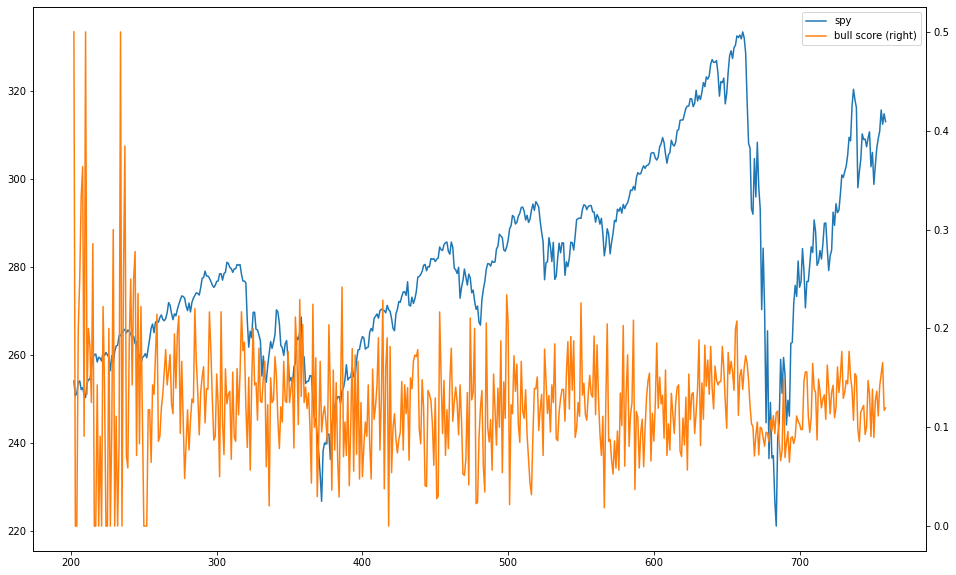

In [62]:
df_2_csv[['spy', 'bull score']].loc['2019-07-10':].plot(secondary_y='bull score', figsize=(16, 10));

In [63]:
df_2_csv[['spy', 'bear score']].loc['2019-07-10':].plot(secondary_y='bear score', figsize=(16, 10));

In [64]:
## fourier transform

close_fft = np.fft.fft(np.asarray(df_2_csv['bull score'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df['fft'].tolist())

for num_ in [10, 30]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    df_2_csv['fourier bull '+str(num_)]=np.fft.ifft(fft_list_m10)

close_fft = np.fft.fft(np.asarray(df_2_csv['bear score'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df['fft'].tolist())

for num_ in [10, 30]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    df_2_csv['fourier bear '+str(num_)]=np.fft.ifft(fft_list_m10)

In [65]:
df_2_csv[['bull score', 'fourier bull 10', 'fourier bull 30']].plot(figsize=(16, 10));

C:\Users\nanen\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\nanen\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


C:\Users\nanen\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\nanen\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


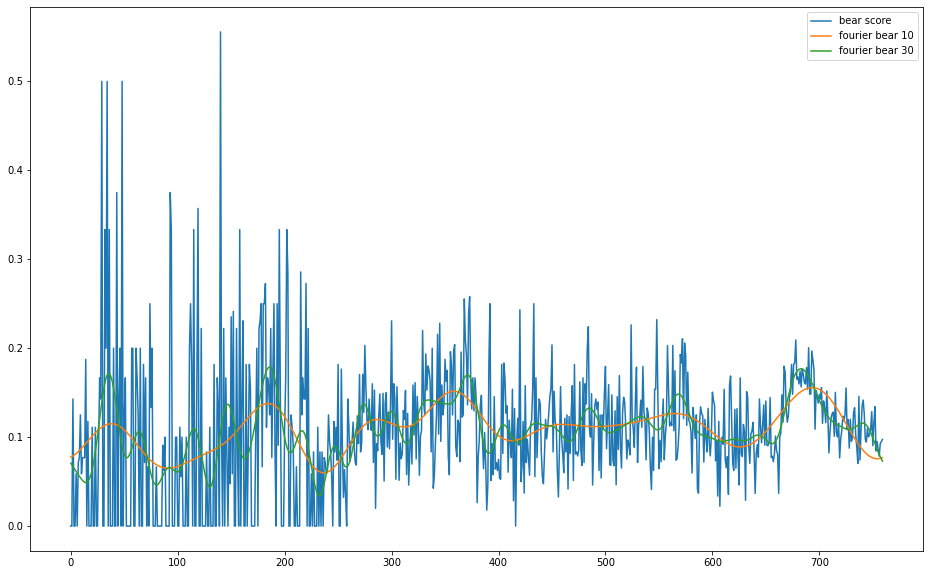

In [66]:
df_2_csv[['bear score', 'fourier bear 10', 'fourier bear 30']].plot(figsize=(16, 10));

In [67]:
#normalize
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
df_2_csv['norm_price']=sc.fit_transform(df_2_csv['spy'].to_numpy().reshape(-1, 1))
df_2_csv['spy log']=np.log(df_2['spy']/df_2_csv['spy'].shift(1))
df_2_csv['norm_bull']=sc.fit_transform(df_2_csv['bull score'].to_numpy().reshape(-1, 1))
df_2_csv['norm_bear']=sc.fit_transform(df_2_csv['bear score'].to_numpy().reshape(-1, 1))
df_2_csv['norm_fourier_bull_10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_2_csv['fourier bull 10'].to_numpy()])).reshape(-1, 1))
df_2_csv['norm_fourier_bear_10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_2_csv['fourier bear 10'].to_numpy()])).reshape(-1, 1))
df_2_csv['norm_fourier_bull_30']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_2_csv['fourier bull 30'].to_numpy()])).reshape(-1, 1))
df_2_csv['norm_fourier_bear_30']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_2_csv['fourier bear 30'].to_numpy()])).reshape(-1, 1))


<ipython-input-67-5647efa45dc4>:8: ComplexWarning: Casting complex values to real discards the imaginary part
  df_2_csv['norm_fourier_bull_10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_2_csv['fourier bull 10'].to_numpy()])).reshape(-1, 1))
<ipython-input-67-5647efa45dc4>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  df_2_csv['norm_fourier_bear_10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_2_csv['fourier bear 10'].to_numpy()])).reshape(-1, 1))
<ipython-input-67-5647efa45dc4>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  df_2_csv['norm_fourier_bull_30']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_2_csv['fourier bull 30'].to_numpy()])).reshape(-1, 1))
<ipython-input-67-5647efa45dc4>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  df_2_csv['norm_fourier_bear_30']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_2_csv['fourier bear 30'].

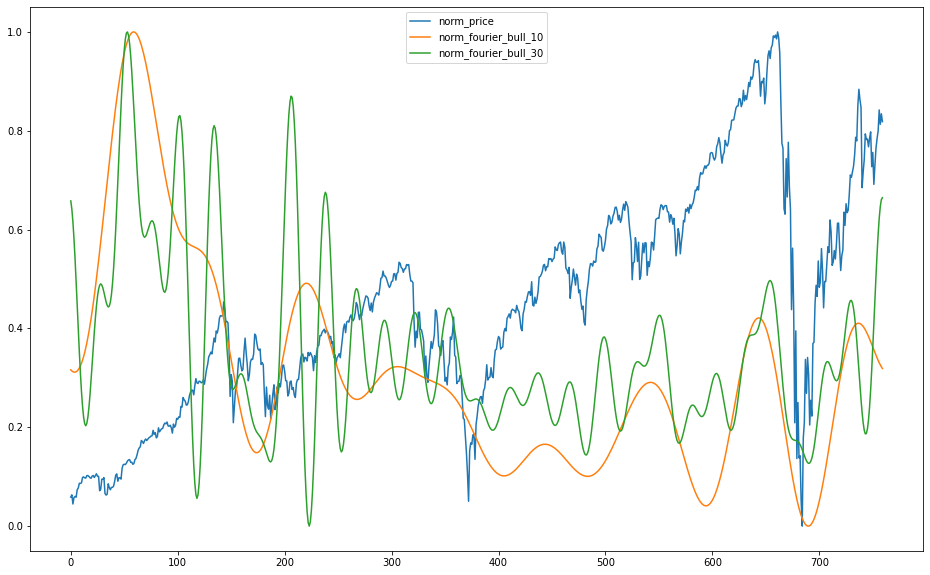

In [68]:
df_2_csv[['norm_price', 'norm_fourier_bull_10', 'norm_fourier_bull_30']].plot(figsize=(16, 10));

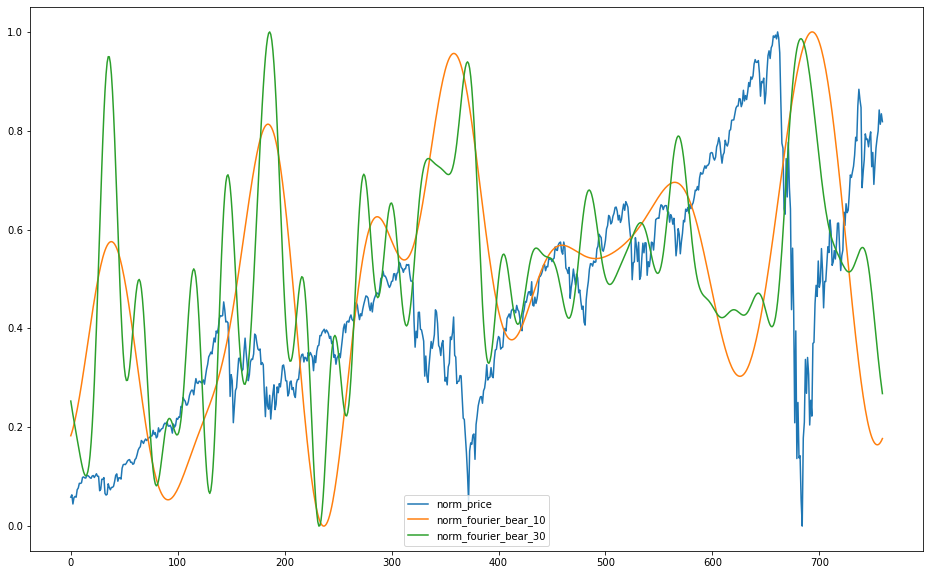

In [69]:
df_2_csv[['norm_price', 'norm_fourier_bear_10', 'norm_fourier_bear_30']].plot(figsize=(16, 10));

# strategy development

## develop strategy using spread between sentiment score and spy

In [70]:
df_1_csv[['norm_fourier20', 'norm_price']].corr()

norm_fourier20  norm_price
norm_fourier20        1.000000    0.314321
norm_price            0.314321    1.000000

In [71]:
rolling_corr=df_1_csv['norm_price'].rolling(window=14).corr(df_1_csv['norm_fourier20'])
corr=df_1[['norm_fourier20', 'norm_price']].corr().iloc[0, 1]

mean=rolling_corr.mean()
print(mean)

std=np.std(rolling_corr)
print(std)

0.3918096398387383
0.5415269284940862


In [72]:
ax = rolling_corr.plot(figsize=(16, 10))  
ax.axhline(corr, c='r'); 

In [74]:
df_1_csv['rolling_corr']=rolling_corr

In [75]:
#rolling correlation vs price
#strategy could involve opening short position when correlation drops but spy continues to rise
ax=df_1_csv[['rolling_corr', 'norm_price']].plot(secondary_y='norm_price', figsize=(16, 10))
ax.axhline(mean-std, c='black'); 
ax.axhline(mean, c='red');

## deep learning model based on bull/bear sentiment scores

In [76]:
#function for numpy array manipulation in next cell
def remove_first(array):
    new_array=[]
    for x in array:
        new_array.append(x[1:])
    return np.asarray(new_array)

In [77]:
# get relevant columns and divide into train and test sets
df=df_2_csv[['norm_price', 'norm_bull', 'norm_bear', 'norm_fourier_bull_10', 
           'norm_fourier_bear_10', 'norm_fourier_bull_30', 'norm_fourier_bear_30']].to_numpy()
window=15
gap=1
data=[]
for x in range(len(df)-window): 
    data.append(df[x:x+window])
data=np.asarray(data)
train=data[:-50]
test=data[-50:]
np.random.shuffle(train)

X_train=[]
y_train=[]
for d in train:
    X_train.append(remove_first(d[:window-gap]))
    y_train.append(d[-1][0])

X_test=[]
y_test=[]
for d in test:
    X_test.append(remove_first(d[:window-gap]))
    y_test.append(d[-1][0])
    
X_train=np.asarray(X_train)
y_train=np.asarray(y_train)
X_test=np.asarray(X_test)
y_test=np.asarray(y_test)

In [78]:
#train lstm model
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

mc=tf.keras.callbacks.ModelCheckpoint(filepath='lstm_bullbear_sentiment_1.h5', monitor='val_loss', save_best_only=True)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(48, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    tf.keras.layers.LSTM(48,return_sequences=True),
    tf.keras.layers.LSTM(48),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(12, activation="relu"),
    tf.keras.layers.Dense(1),
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, validation_data= (X_test, y_test), epochs=250, callbacks=[mc]).history

Epoch 1/250
22/22 [==============================] - 1s 63ms/step - loss: 0.0794 - accuracy: 0.0000e+00 - val_loss: 0.0856 - val_accuracy: 0.0000e+00
Epoch 2/250
22/22 [==============================] - 0s 18ms/step - loss: 0.0457 - accuracy: 0.0000e+00 - val_loss: 0.0707 - val_accuracy: 0.0000e+00
Epoch 3/250
22/22 [==============================] - 0s 17ms/step - loss: 0.0385 - accuracy: 0.0000e+00 - val_loss: 0.0753 - val_accuracy: 0.0000e+00
Epoch 4/250
22/22 [==============================] - 0s 15ms/step - loss: 0.0349 - accuracy: 0.0014 - val_loss: 0.0552 - val_accuracy: 0.0000e+00
Epoch 5/250
22/22 [==============================] - 0s 15ms/step - loss: 0.0297 - accuracy: 0.0014 - val_loss: 0.0516 - val_accuracy: 0.0000e+00
Epoch 6/250
22/22 [==============================] - 0s 14ms/step - loss: 0.0286 - accuracy: 0.0014 - val_loss: 0.0615 - val_accuracy: 0.0000e+00
Epoch 7/250
22/22 [==============================] - 0s 13ms/step - loss: 0.0279 - accuracy: 0.0014 - val_loss: 

Epoch 110/250
22/22 [==============================] - 0s 14ms/step - loss: 9.9898e-04 - accuracy: 0.0029 - val_loss: 0.0662 - val_accuracy: 0.0000e+00
Epoch 111/250
22/22 [==============================] - 0s 14ms/step - loss: 0.0010 - accuracy: 0.0029 - val_loss: 0.0684 - val_accuracy: 0.0000e+00
Epoch 112/250
22/22 [==============================] - 0s 14ms/step - loss: 0.0011 - accuracy: 0.0029 - val_loss: 0.0724 - val_accuracy: 0.0000e+00
Epoch 113/250
22/22 [==============================] - 0s 14ms/step - loss: 9.7692e-04 - accuracy: 0.0029 - val_loss: 0.0593 - val_accuracy: 0.0000e+00
Epoch 114/250
22/22 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.00 - 0s 14ms/step - loss: 0.0010 - accuracy: 0.0029 - val_loss: 0.0701 - val_accuracy: 0.0000e+00
Epoch 115/250
22/22 [==============================] - 0s 14ms/step - loss: 0.0014 - accuracy: 0.0029 - val_loss: 0.0745 - val_accuracy: 0.0000e+00
Epoch 116/250
22/22 [==============================] - 0s 14ms

Epoch 163/250
22/22 [==============================] - 0s 14ms/step - loss: 7.3774e-04 - accuracy: 0.0029 - val_loss: 0.0580 - val_accuracy: 0.0000e+00
Epoch 164/250
22/22 [==============================] - 0s 14ms/step - loss: 0.0011 - accuracy: 0.0029 - val_loss: 0.0633 - val_accuracy: 0.0000e+00
Epoch 165/250
22/22 [==============================] - 0s 14ms/step - loss: 8.3371e-04 - accuracy: 0.0029 - val_loss: 0.0649 - val_accuracy: 0.0000e+00
Epoch 166/250
22/22 [==============================] - 0s 14ms/step - loss: 6.6310e-04 - accuracy: 0.0029 - val_loss: 0.0729 - val_accuracy: 0.0000e+00
Epoch 167/250
22/22 [==============================] - 0s 14ms/step - loss: 6.7791e-04 - accuracy: 0.0029 - val_loss: 0.0658 - val_accuracy: 0.0000e+00
Epoch 168/250
22/22 [==============================] - 0s 14ms/step - loss: 0.0010 - accuracy: 0.0029 - val_loss: 0.0753 - val_accuracy: 0.0000e+00
Epoch 169/250
22/22 [==============================] - 0s 14ms/step - loss: 0.0012 - accuracy: 0

In [79]:
#loss plot
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(len(acc))

plt.figure(figsize = (16,12))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

<Figure size 432x288 with 0 Axes>

In [80]:
#predictions
pred=model.predict(X_test)
    
df_predictions=pd.DataFrame(y_test, columns = ['price']) 
df_predictions['prediction']=pred

df_predictions.plot(figsize=(18,12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

In [81]:
print('MEA: ', sum(tf.keras.metrics.mean_absolute_error(y_test, pred).numpy())/len(y_test))

MEA:  0.21702432841062547
